Configure path envirorment

In [1]:
import sys
import os
sys.path.append(os.getcwd()[:-4]) 

Import Libraries

In [2]:
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from examples.traveling_salesman import TravelingSalesmanACO
from src.pheronomone_update.standart_phero_update import StandartPheroUpdate
from src.pheronomone_update.rank_phero_update import RankPheroUpdate
from src.pheronomone_update.elitism_phero_update import ElitismPheroUpdate

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Load data

In [3]:
# Load the traveling salesman problem - SGB128
os.system(f'wget -P ../assets https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_dist.txt ')

--2024-08-20 15:23:54--  https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_dist.txt
Carregou certificado CA "/etc/ssl/certs/ca-certificates.crt"
Resolvendo people.sc.fsu.edu (people.sc.fsu.edu)... 144.174.0.22
Conectando-se a people.sc.fsu.edu (people.sc.fsu.edu)|144.174.0.22|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 98541 (96K) [text/plain]
Salvando em: “../assets/sgb128_dist.txt.1”

     0K .......... .......... .......... .......... .......... 51%  146K 0s
    50K .......... .......... .......... .......... ......    100% 7,46M=0,3s

2024-08-20 15:23:56 (276 KB/s) - “../assets/sgb128_dist.txt.1” salvo [98541/98541]



0

In [5]:
dist = []
n_cities = 128
with open('../assets/sgb128_dist.txt', 'r') as file:
    for line in file:
        if line[0] == '#': continue
        dist.append([int(d) for d in line.split()])
distance_matrix = np.array(dist)

### Grid search considering rank based pheromone update w/ the params:
- alpha: [1...10]
- beta: [10...1]
- rank: [1...10]

In [36]:
params = {
    'n_ants': n_cities,
    'n_paths': n_cities,
    'n_generations': 50,
    'alpha': 1,
    'beta': 5,
    'distance_matrix': distance_matrix
}

alpha = [1,5,10]
beta = [10,5,1]
rank = [1,5,10]
combinations = itertools.product(alpha,beta,rank)

results = list()
for a,b,r in tqdm(combinations):
    params['alpha'] = a
    params['beta'] = b

    model = TravelingSalesmanACO(**params)
    model.set_phero_update(RankPheroUpdate(Q=1500,rank=r))
    params['best_fitness'], _ = model.simulate()
    params['rank'] = r
    
    results.append(params.copy())
    del params['best_fitness']
    del params['rank']

27it [10:57, 24.36s/it]


In [37]:
df = pd.DataFrame(results)
df.sort_values(by='best_fitness',ascending=True,inplace=True)
print("Best result and parameters:")
best = df.iloc[0]
best

Best result and parameters:


n_ants                                                           128
n_paths                                                          128
n_generations                                                     50
alpha                                                              1
beta                                                               5
distance_matrix    [[1, 966, 1513, 2964, 1149, 927, 1611, 1510, 3...
best_fitness                                                 21460.0
rank                                                               5
Name: 4, dtype: object

Creating the ant colony model with best params

In [38]:
params = {
    'n_ants': n_cities,
    'n_paths': n_cities,
    'n_generations': 50,
    'alpha': best['alpha'],
    'beta': best['beta'],
    'distance_matrix': distance_matrix
}

model = TravelingSalesmanACO(**params)
model.set_phero_update(RankPheroUpdate(Q=1500,rank=best['rank']))
model.simulate()

(np.float64(21840.0),
 array([121,  24, 110,  50,  11,  77,  81,  44,  78,  23, 108,  88, 116,
         60,  39,  68,  70,  47,  69,  71,   0,  90,   4,  93, 115,   9,
         37,  21,  72,  33,  79,  20,  51,  54, 118, 112, 117,  92,   3,
         89,  29, 111,  74, 114,  17,  53,  91,  41,  86, 107, 113, 124,
         49,  48,  58,  12,  36,  56,  96,  97,  87,  27,  26,  16,  52,
        120,  55,  18,  45,  61, 122, 101,  46,  82,  25,  85,  99,  84,
         31,   1,  75,  32, 123,  63,  57,  30,  73,  59, 109,  62,  66,
         40,   7,  98,   8,  38, 104, 102, 106, 125,  34,  76,  43,  94,
         64,  14,  15,  35, 105,  83,  13, 100, 126, 127,  65,  22,  95,
         80,   5, 119, 103,  42,  28,  10,  19,   2,  67,   6]))

Running the Optimization for Ten Steps

In [39]:
steps = 10
fitness_evolution = [] # Best fitness evolution for executions
history_individuals = [] # Mantain all the history ants from last execution
for i in range(steps):
    _, best_individual = model.simulate()
    fitness_evolution.append([min(model.fitness(generation)) for generation in model.history_ants])
    history_individuals = np.array(model.history_ants)

fitness_evolution = np.array(fitness_evolution)
print('Individual:', best_individual)
print('Best result:', model.fitness([best_individual])[0])

Individual: [ 27  26  18  55 120  68  70  47  69  71   0  90   4  93 115 110  50  99
  84  31   1  75  32 123  12  58  48  49   2  64  94  62  66  40   7  98
   8  38 104 113 124 117  14  15  35 105  83  36  56  96 109  59  73  34
  76  43  91  41  86 107 111  29  89   3  92 119   5  80 126 127  65 125
 106  39  60 116  88 108  72  21  37   9  77  11  10  28  25  85  97  87
 103  54 118 112  16  52  79  20  51  57  81  44  78  23  61  45  19  24
 121   6 122 101  46  82  74 114  13 100  22  95  63  17  53  33  30 102
  67  42]
Best result: 21653.0


Visualizing the mean fitness and best fitness evolution for last execution

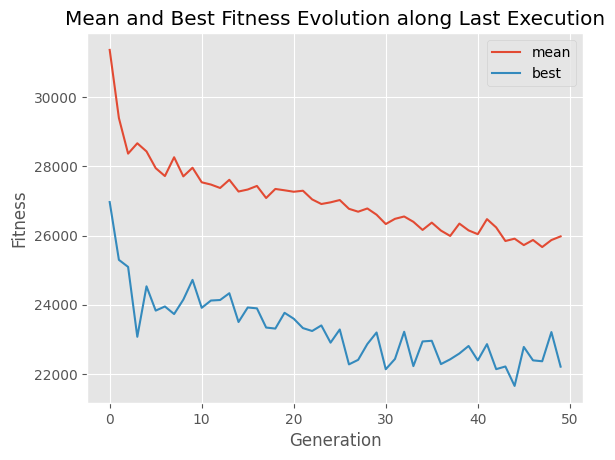

In [40]:
mean_fitness = np.array([np.mean(model.fitness(generation)) for generation in history_individuals])
max_fitness = np.array([np.min(model.fitness(generation)) for generation in history_individuals])

x = np.arange(mean_fitness.shape[0])
plt.plot(x,mean_fitness,label='mean')
plt.plot(x,max_fitness, label='best')
plt.title('Mean and Best Fitness Evolution along Last Execution')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

Visualizing Best Fitness Evolution for each execution

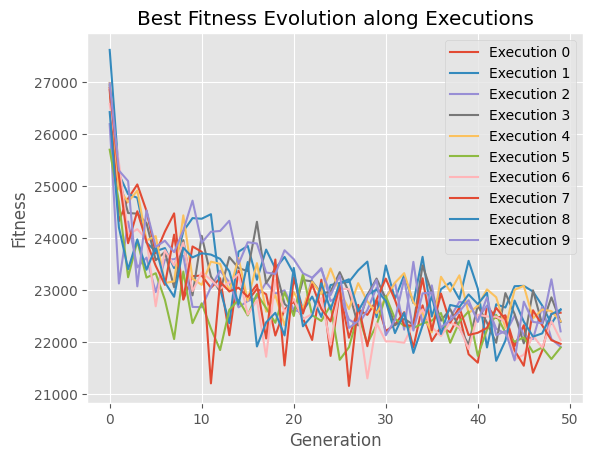

In [41]:
x = np.arange(fitness_evolution.shape[1])
for i,execution in enumerate(fitness_evolution):
    plt.plot(x, execution, label = f"Execution {i}")
plt.title('Best Fitness Evolution along Executions')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()

### Comparison between pheromone update functions
- Standart
- Elitism
- Rank Based

In [31]:
params = {
    'n_ants': n_cities,
    'n_paths': n_cities,
    'n_generations': 50,
    'alpha': 1,
    'beta': 5,
    'distance_matrix': distance_matrix
}
model = TravelingSalesmanACO(**params)

fitness_comparation = []

In [42]:
model.set_phero_update(StandartPheroUpdate(Q=1500,evaporation_rate=0.5))
model.simulate()
fitness_comparation.append([min(model.fitness(generation)) for generation in model.history_ants])

In [33]:
model.set_phero_update(RankPheroUpdate(Q = 1500, evaporation_rate = 0.5, rank = 5))
model.simulate()
fitness_comparation.append([min(model.fitness(generation)) for generation in model.history_ants])

In [34]:
model.set_phero_update(ElitismPheroUpdate(Q = 1500, evaporation_rate = 0.5, best_rate = 0.1))
model.simulate()
fitness_comparation.append([min(model.fitness(generation)) for generation in model.history_ants])

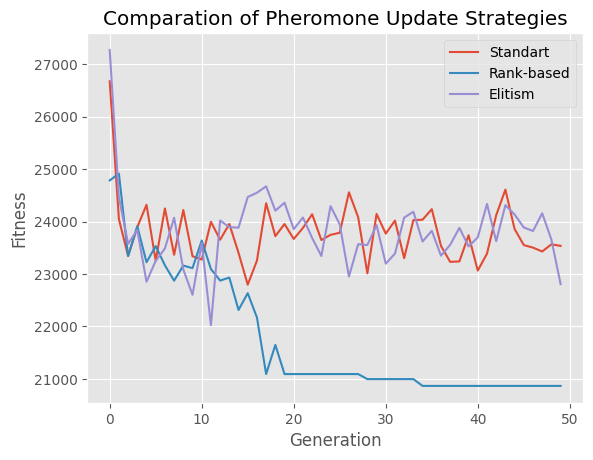

In [35]:
x = np.arange(fitness_evolution.shape[1])
plt.plot(x,fitness_comparation[0],label='Standart')
plt.plot(x,fitness_comparation[1],label='Rank-based')
plt.plot(x,fitness_comparation[2],label='Elitism')

plt.title('Comparation of Pheromone Update Strategies')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.show()